In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

df_train = pd.read_csv("data/smoker_train.csv")
df_train = df_train.drop_duplicates()

# Allgemeine Analyse

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33467 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  33467 non-null  int64  
 1   height(cm)           33467 non-null  int64  
 2   weight(kg)           33467 non-null  int64  
 3   waist(cm)            33467 non-null  float64
 4   eyesight(left)       33467 non-null  float64
 5   eyesight(right)      33467 non-null  float64
 6   hearing(left)        33467 non-null  int64  
 7   hearing(right)       33467 non-null  int64  
 8   systolic             33467 non-null  int64  
 9   relaxation           33467 non-null  int64  
 10  fasting blood sugar  33467 non-null  int64  
 11  Cholesterol          33467 non-null  int64  
 12  triglyceride         33467 non-null  int64  
 13  HDL                  33467 non-null  int64  
 14  LDL                  33467 non-null  int64  
 15  hemoglobin           33467 non-null  floa

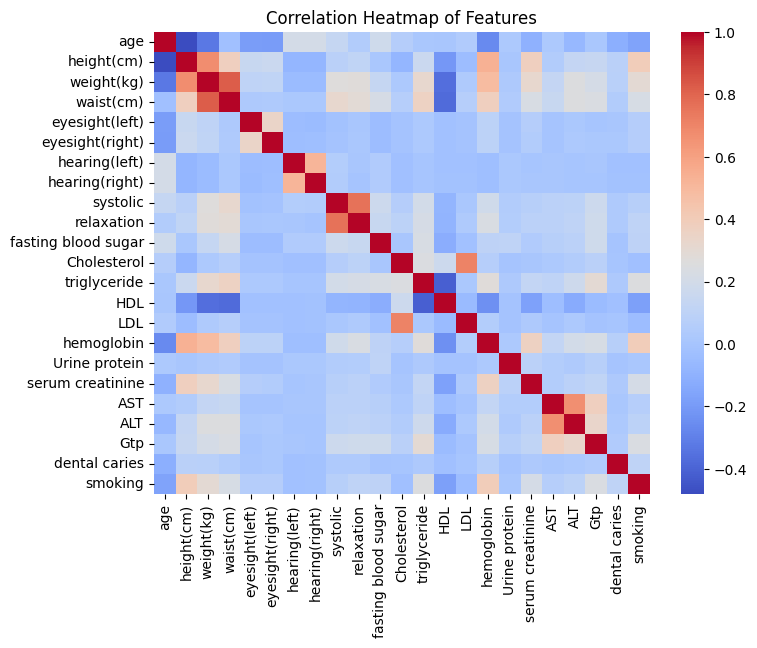

In [35]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# Machine Learning Modell

In [ ]:
# Use all columns except 'weight(kg)' and smoking as features
X = df_train[['height(cm)', 'waist(cm)', 'age']]
y = df_train['weight(kg)']

# Split data into training and testing sets (using only training set for comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training der Modelle
lr_model = LinearRegression().fit(X_train_1, y_train_1)

y_pred = lr_model.predict(X_test_1)

print(f"Intercept: {lr_model.intercept_}")
for name, coef in zip(X.columns, lr_model.coef_):
    print(f"Coefficient for {name}: {coef}")

mse = mean_squared_error(y_test_1, y_pred)
print(f"Test Mean Squared Error: {mse}")

Intercept: -88.19795969670112
Coefficient for height(cm): 0.48261718334363224
Coefficient for waist(cm): 0.9360556931683
Coefficient for age: -0.15277880503622543
Coefficient for relaxation: 0.06046176534277436
Test Mean Squared Error: 24.341582330708672
